In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import shap
import re
from sklearn.metrics import mean_squared_log_error
from nltk.corpus import stopwords
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import OneHotEncoder

In [29]:
data_path = './Participants_Data'
raw_test = pd.read_excel(data_path + '/Data_Test.xlsx')
raw_train = pd.read_excel(data_path + '/Data_Train.xlsx')
raw_test['flag']='test'
raw_train['flag'] = 'train'

In [30]:
data = pd.concat([raw_train,raw_test],sort=False)
data['Author'] = data['Author'].replace('[^\w\s]','')
data['Author'] = data['Author'].apply(lambda x: re.sub('[^a-zA-Z0-9 \n\.]', ' ', x))

In [31]:
def edition_yr(x):
    try:
        if int(x[-4:])>0:
            return x[-4:]
    except:
        return ''

In [32]:
 def edition_month(x):
    try:
        if x[-8:-5] in ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']:
            return x[-8:-5]
        else:
            return ''
    except:
        return ''

In [33]:
def find_reviews(x):
    return x[:3]

In [34]:
data['Reviews'] = data['Reviews'].apply(lambda x:find_reviews(x)).astype('float')

In [35]:
data['Edition_yr'] = data['Edition'].apply(lambda x: edition_yr(x))
data['Edition_month'] = data['Edition'].apply(lambda x: edition_month(x))
data['Edition_typ'] = data['Edition'].apply(lambda x: x[:x.find(',')]) 

In [36]:
data['Edition'] = data['Edition'].replace('[^\w\s]','')
data['Edition'] = data['Edition'].apply(lambda x: re.sub('[^a-zA-Z0-9 \n\.]', ' ', x))

In [37]:
def numeric_feat_new(data_uniq,column,name):
    column.append('Price')
    data_num_feat = data_uniq.loc[data_uniq['flag']=='train'][column]
    data_num_feat[name+'_mean'] = data_num_feat.groupby(column[:-1])['Price'].transform(np.mean)
    data_num_feat[name+'_min'] = data_num_feat.groupby(column[:-1])['Price'].transform(np.min)
    data_num_feat[name+'_max'] = data_num_feat.groupby(column[:-1])['Price'].transform(np.max)
    data_num_feat[name+'_median'] = data_num_feat.groupby(column[:-1])['Price'].transform(np.median)
    data_num_feat.drop(columns=['Price'],inplace=True)
    data_num_feat.drop_duplicates(keep='first',inplace=True)
    data_uniq = data_uniq.merge(data_num_feat,how='left',left_on=column[:-1],right_on=column[:-1])
    return data_uniq

In [38]:
def numeric_feat(data_uniq,column,name):
    column.append('Price')
    data_num_feat = data_uniq.loc[data_uniq['flag']=='train'][column]
    data_num_feat[name+'_mean'] = data_num_feat.groupby(column[:-1])['Price'].transform(np.mean)
    data_num_feat[name+'_median'] = data_num_feat.groupby(column[:-1])['Price'].transform(np.median)
    data_num_feat[name+'_min'] = data_num_feat.groupby(column[:-1])['Price'].transform(np.min)
    data_num_feat[name+'_max'] = data_num_feat.groupby(column[:-1])['Price'].transform(np.max)
    data_num_feat.drop(columns=['Price'],inplace=True)
    data_num_feat.drop_duplicates(keep='first',inplace=True)
    data_uniq = data_uniq.merge(data_num_feat,how='left',left_on=column[:-1],right_on=column[:-1])
    return data_uniq

In [39]:
data = numeric_feat_new(data,['Author'],'Author')
data = numeric_feat_new(data,['Genre'],'Genre')
data = numeric_feat_new(data,['Edition_typ'],'Edition_typ')
data = numeric_feat_new(data,['Edition_month'],'Edition_month')
data = numeric_feat_new(data,['Edition_yr'],'Edition_yr')
data = numeric_feat_new(data,['BookCategory'],'BookCategory')
data = numeric_feat_new(data,['Reviews'],'Reviews')
data = numeric_feat(data,['Genre','BookCategory'],'Genre_BookCategory')
data = numeric_feat(data,['Genre','BookCategory','Edition_typ'],'Genre_BookCategory_Eidtion_typ')
data = numeric_feat(data,['BookCategory','Edition_typ'],'BookCategory_Eidtion_typ')
data = numeric_feat(data,['Genre','Edition_typ'],'Genre_Eidtion_typ')
data = numeric_feat(data,['Genre','Author'],'Author_Genre')
data = numeric_feat(data,['Author','BookCategory'],'Author_BookCategory')

In [40]:
data['Author_Genre_ratio'] = data['Author_mean']/data['Genre_mean']
data['Author_BookCategory_ratio'] = data['Author_mean']/data['BookCategory_mean']
data['Author_Edition_typ_ratio'] = data['Author_mean']/data['Edition_typ_mean']
data['Author_Genre_BookCategory_ratio'] = data['Author_mean']/data['Genre_BookCategory_mean']
data['Author_Genre_BookCategory_Eidtion_typ_ratio'] = data['Author_mean']/data['Genre_BookCategory_Eidtion_typ_mean']
data['Author_BookCategory_Eidtion_typ_ratio'] = data['Author_mean']/data['BookCategory_Eidtion_typ_mean']
data['Author_Genre_Eidtion_typ_ratio'] = data['Author_mean']/data['Genre_Eidtion_typ_mean']

In [30]:
data.dtypes

Title                                           object
Author                                          object
Edition                                         object
Reviews                                        float64
Ratings                                         object
Synopsis                                        object
Genre                                           object
BookCategory                                    object
Price                                          float64
flag                                            object
Edition_yr                                      object
Edition_month                                   object
Edition_typ                                     object
Author_mean                                    float64
Author_min                                     float64
Author_max                                     float64
Author_median                                  float64
Genre_mean                                     float64
Genre_min 

In [41]:
data_encoded = data.drop(columns=['Ratings'])
# data_encoded = pd.get_dummies(data_encoded,columns=['Author','Edition','Genre','BookCategory','Edition_yr','Edition_month',
#                                                     'Edition_typ'],drop_first=True)

In [42]:
stop = stopwords.words('english')

In [43]:
data_encoded['Synopsis_feat'] = data_encoded['Synopsis']
data_encoded['Synopsis_feat'] = data_encoded['Synopsis_feat'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data_encoded['Synopsis_feat'] = data_encoded['Synopsis_feat'].replace('[^\w\s]','')
data_encoded['Synopsis_feat'] = data_encoded['Synopsis_feat'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data_encoded['Synopsis_feat'] = data_encoded['Synopsis_feat'].apply(lambda x: re.sub('[^a-zA-Z \n\.]', ' ', x))
data_encoded['Synopsis_feat'] = data_encoded['Synopsis_feat'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data_encoded['Synopsis_feat'] = data_encoded['Synopsis_feat'].apply(lambda x: " ".join(x for x in x.split() if len(x) > 2))
data_encoded['Synopsis_feat'] = data_encoded['Synopsis_feat'].apply(lambda x: " ".join(x for x in set(x.split())))

In [44]:
data_encoded['Title_feat'] = data_encoded['Title']
data_encoded['Title_feat'] = data_encoded['Title_feat'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data_encoded['Title_feat'] = data_encoded['Title_feat'].replace('[^\w\s]','')
data_encoded['Title_feat'] = data_encoded['Title_feat'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data_encoded['Title_feat'] = data_encoded['Title_feat'].apply(lambda x: re.sub('[^a-zA-Z \n\.]', ' ', x))
data_encoded['Title_feat'] = data_encoded['Title_feat'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data_encoded['Title_feat'] = data_encoded['Title_feat'].apply(lambda x: " ".join(x for x in x.split() if len(x) > 2))
data_encoded['Title_feat'] = data_encoded['Title_feat'].apply(lambda x: " ".join(x for x in set(x.split())))

In [21]:
list(data_encoded.columns)

[u'Title',
 u'Author',
 u'Edition',
 u'Reviews',
 u'Synopsis',
 u'Genre',
 u'BookCategory',
 u'Price',
 'flag',
 'Edition_yr',
 'Edition_month',
 'Edition_typ',
 'Author_mean',
 'Author_min',
 'Author_max',
 'Author_median',
 'Genre_mean',
 'Genre_min',
 'Genre_max',
 'Genre_median',
 'Edition_typ_mean',
 'Edition_typ_min',
 'Edition_typ_max',
 'Edition_typ_median',
 'Edition_month_mean',
 'Edition_month_min',
 'Edition_month_max',
 'Edition_month_median',
 'Edition_yr_mean',
 'Edition_yr_min',
 'Edition_yr_max',
 'Edition_yr_median',
 'BookCategory_mean',
 'BookCategory_min',
 'BookCategory_max',
 'BookCategory_median',
 'Reviews_mean',
 'Reviews_min',
 'Reviews_max',
 'Reviews_median',
 'Genre_BookCategory_mean',
 'Genre_BookCategory_median',
 'Genre_BookCategory_min',
 'Genre_BookCategory_max',
 'Genre_BookCategory_Eidtion_typ_mean',
 'Genre_BookCategory_Eidtion_typ_median',
 'Genre_BookCategory_Eidtion_typ_min',
 'Genre_BookCategory_Eidtion_typ_max',
 'BookCategory_Eidtion_typ_mean',
 'BookCategory_Eidtion_typ_median',
 'BookCategory_Eidtion_typ_min',
 'BookCategory_Eidtion_typ_max',
 'Genre_Eidtion_typ_mean',
 'Genre_Eidtion_typ_median',
 'Genre_Eidtion_typ_min',
 'Genre_Eidtion_typ_max',
 'Author_Genre_mean',
 'Author_Genre_median',
 'Author_Genre_min',
 'Author_Genre_max',
 'Author_BookCategory_mean',
 'Author_BookCategory_median',
 'Author_BookCategory_min',
 'Author_BookCategory_max',
 'Author_Genre_ratio',
 'Author_BookCategory_ratio',
 'Author_Edition_typ_ratio',
 'Author_Genre_BookCategory_ratio',
 'Author_Genre_BookCategory_Eidtion_typ_ratio',
 'Author_BookCategory_Eidtion_typ_ratio',
 'Author_Genre_Eidtion_typ_ratio',
 'Synopsis_feat',
 'Title_feat']

In [45]:
mapper = DataFrameMapper([
#     (['word_count', 'avg_word_length', 'char_count', 'word_density', 'noun_count', 'verb_count', 'adj_count', 'adv_count'],None),
    ('Synopsis_feat',CountVectorizer(binary=True, ngram_range=(0,1))),
    ('Synopsis_feat',TfidfVectorizer(smooth_idf=True)) ,
    ('Title_feat',CountVectorizer(binary=True, ngram_range=(0,1))),
    ('Title_feat',TfidfVectorizer(smooth_idf=True)) 
])

In [46]:
data_encoded_mapped = mapper.fit_transform(data_encoded)

In [25]:
from sklearn.decomposition import PCA

In [26]:
data_encoded_mapped.shape

(7797L, 99585L)

In [27]:
pca = PCA(n_components=10000, whiten=False)
data_encoded_mapped_PCA = pca.fit_transform(data_encoded_mapped)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [15]:
X = data_encoded.loc[data_encoded['flag']=='train'].drop(columns=['flag','Price'])
y = data_encoded.loc[data_encoded['flag']=='train']['Price']

In [36]:
test = data_encoded.loc[data_encoded['flag']=='train'].drop(columns=['flag','Price'])

In [128]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=42)

In [38]:
from catboost import CatBoostRegressor

In [39]:
cbc = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    random_strength=0.1,
    depth=8,
    eval_metric='MSLE',
    leaf_estimation_method='Gradient',
    l2_leaf_reg=5
)

In [118]:
cbc_poly = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    random_strength=0.1,
    depth=8,
    eval_metric='MSLE',
    leaf_estimation_method='Gradient',
    l2_leaf_reg=5
)

In [117]:
from sklearn.preprocessing import PolynomialFeatures

In [47]:
cbc.fit(X_train[list(feat_imp.loc[feat_imp['Importances']>0.1]['Feature Index'])],y_train)

0:	learn: 5.0997390	total: 204ms	remaining: 3m 23s
1:	learn: 2.6541757	total: 405ms	remaining: 3m 21s
2:	learn: 1.6357274	total: 610ms	remaining: 3m 22s
3:	learn: 1.0991429	total: 815ms	remaining: 3m 22s
4:	learn: 0.7814728	total: 1.03s	remaining: 3m 24s
5:	learn: 0.5761786	total: 1.23s	remaining: 3m 24s
6:	learn: 0.4381469	total: 1.44s	remaining: 3m 23s
7:	learn: 0.3426836	total: 1.65s	remaining: 3m 24s
8:	learn: 0.2763012	total: 1.86s	remaining: 3m 24s
9:	learn: 0.2250833	total: 2.06s	remaining: 3m 23s
10:	learn: 0.1902559	total: 2.27s	remaining: 3m 24s
11:	learn: 0.1642018	total: 2.49s	remaining: 3m 25s
12:	learn: 0.1449163	total: 2.7s	remaining: 3m 24s
13:	learn: 0.1300150	total: 2.9s	remaining: 3m 24s
14:	learn: 0.1190882	total: 3.1s	remaining: 3m 23s
15:	learn: 0.1101584	total: 3.3s	remaining: 3m 22s
16:	learn: 0.1025307	total: 3.5s	remaining: 3m 22s
17:	learn: 0.0961541	total: 3.72s	remaining: 3m 23s
18:	learn: 0.0933189	total: 3.92s	remaining: 3m 22s
19:	learn: 0.0908508	total:

158:	learn: 0.0800583	total: 32.2s	remaining: 2m 50s
159:	learn: 0.0800784	total: 32.5s	remaining: 2m 50s
160:	learn: 0.0798215	total: 32.7s	remaining: 2m 50s
161:	learn: 0.0798243	total: 32.9s	remaining: 2m 50s
162:	learn: 0.0798462	total: 33.1s	remaining: 2m 49s
163:	learn: 0.0797174	total: 33.3s	remaining: 2m 49s
164:	learn: 0.0797294	total: 33.5s	remaining: 2m 49s
165:	learn: 0.0797284	total: 33.8s	remaining: 2m 49s
166:	learn: 0.0797476	total: 34s	remaining: 2m 49s
167:	learn: 0.0797652	total: 34.3s	remaining: 2m 49s
168:	learn: 0.0798101	total: 34.5s	remaining: 2m 49s
169:	learn: 0.0797967	total: 34.7s	remaining: 2m 49s
170:	learn: 0.0797067	total: 34.9s	remaining: 2m 49s
171:	learn: 0.0796630	total: 35.2s	remaining: 2m 49s
172:	learn: 0.0796570	total: 35.4s	remaining: 2m 49s
173:	learn: 0.0796666	total: 35.7s	remaining: 2m 49s
174:	learn: 0.0792152	total: 35.9s	remaining: 2m 49s
175:	learn: 0.0791117	total: 36.2s	remaining: 2m 49s
176:	learn: 0.0790973	total: 36.4s	remaining: 2m

314:	learn: 0.0675887	total: 1m 7s	remaining: 2m 26s
315:	learn: 0.0676011	total: 1m 7s	remaining: 2m 26s
316:	learn: 0.0676491	total: 1m 8s	remaining: 2m 26s
317:	learn: 0.0676450	total: 1m 8s	remaining: 2m 26s
318:	learn: 0.0676188	total: 1m 8s	remaining: 2m 26s
319:	learn: 0.0676054	total: 1m 8s	remaining: 2m 25s
320:	learn: 0.0676037	total: 1m 8s	remaining: 2m 25s
321:	learn: 0.0675308	total: 1m 9s	remaining: 2m 25s
322:	learn: 0.0667387	total: 1m 9s	remaining: 2m 25s
323:	learn: 0.0667377	total: 1m 9s	remaining: 2m 24s
324:	learn: 0.0667174	total: 1m 9s	remaining: 2m 24s
325:	learn: 0.0667155	total: 1m 9s	remaining: 2m 24s
326:	learn: 0.0665059	total: 1m 10s	remaining: 2m 24s
327:	learn: 0.0665027	total: 1m 10s	remaining: 2m 24s
328:	learn: 0.0665021	total: 1m 10s	remaining: 2m 23s
329:	learn: 0.0665170	total: 1m 10s	remaining: 2m 23s
330:	learn: 0.0665096	total: 1m 10s	remaining: 2m 23s
331:	learn: 0.0665632	total: 1m 11s	remaining: 2m 23s
332:	learn: 0.0664299	total: 1m 11s	rema

468:	learn: 0.0622643	total: 1m 41s	remaining: 1m 54s
469:	learn: 0.0622669	total: 1m 41s	remaining: 1m 54s
470:	learn: 0.0622673	total: 1m 41s	remaining: 1m 53s
471:	learn: 0.0621512	total: 1m 41s	remaining: 1m 53s
472:	learn: 0.0619508	total: 1m 41s	remaining: 1m 53s
473:	learn: 0.0619240	total: 1m 42s	remaining: 1m 53s
474:	learn: 0.0619293	total: 1m 42s	remaining: 1m 53s
475:	learn: 0.0619345	total: 1m 42s	remaining: 1m 52s
476:	learn: 0.0619215	total: 1m 42s	remaining: 1m 52s
477:	learn: 0.0619249	total: 1m 42s	remaining: 1m 52s
478:	learn: 0.0618853	total: 1m 43s	remaining: 1m 52s
479:	learn: 0.0618032	total: 1m 43s	remaining: 1m 51s
480:	learn: 0.0618041	total: 1m 43s	remaining: 1m 51s
481:	learn: 0.0618050	total: 1m 43s	remaining: 1m 51s
482:	learn: 0.0612782	total: 1m 43s	remaining: 1m 51s
483:	learn: 0.0612827	total: 1m 44s	remaining: 1m 51s
484:	learn: 0.0612707	total: 1m 44s	remaining: 1m 50s
485:	learn: 0.0612124	total: 1m 44s	remaining: 1m 50s
486:	learn: 0.0612040	total:

621:	learn: 0.0579875	total: 2m 15s	remaining: 1m 22s
622:	learn: 0.0579875	total: 2m 15s	remaining: 1m 22s
623:	learn: 0.0579697	total: 2m 15s	remaining: 1m 21s
624:	learn: 0.0579601	total: 2m 15s	remaining: 1m 21s
625:	learn: 0.0579598	total: 2m 16s	remaining: 1m 21s
626:	learn: 0.0579323	total: 2m 16s	remaining: 1m 21s
627:	learn: 0.0579275	total: 2m 16s	remaining: 1m 20s
628:	learn: 0.0579270	total: 2m 16s	remaining: 1m 20s
629:	learn: 0.0579267	total: 2m 17s	remaining: 1m 20s
630:	learn: 0.0579466	total: 2m 17s	remaining: 1m 20s
631:	learn: 0.0579446	total: 2m 17s	remaining: 1m 20s
632:	learn: 0.0579624	total: 2m 17s	remaining: 1m 19s
633:	learn: 0.0579623	total: 2m 18s	remaining: 1m 19s
634:	learn: 0.0579621	total: 2m 18s	remaining: 1m 19s
635:	learn: 0.0579750	total: 2m 18s	remaining: 1m 19s
636:	learn: 0.0579653	total: 2m 18s	remaining: 1m 19s
637:	learn: 0.0579658	total: 2m 18s	remaining: 1m 18s
638:	learn: 0.0579344	total: 2m 19s	remaining: 1m 18s
639:	learn: 0.0579333	total:

775:	learn: 0.0574242	total: 2m 48s	remaining: 48.6s
776:	learn: 0.0574296	total: 2m 48s	remaining: 48.4s
777:	learn: 0.0574296	total: 2m 48s	remaining: 48.2s
778:	learn: 0.0574298	total: 2m 49s	remaining: 47.9s
779:	learn: 0.0574275	total: 2m 49s	remaining: 47.7s
780:	learn: 0.0574262	total: 2m 49s	remaining: 47.5s
781:	learn: 0.0574320	total: 2m 49s	remaining: 47.3s
782:	learn: 0.0574345	total: 2m 49s	remaining: 47.1s
783:	learn: 0.0574347	total: 2m 50s	remaining: 46.9s
784:	learn: 0.0574481	total: 2m 50s	remaining: 46.6s
785:	learn: 0.0574167	total: 2m 50s	remaining: 46.4s
786:	learn: 0.0574200	total: 2m 50s	remaining: 46.2s
787:	learn: 0.0574203	total: 2m 51s	remaining: 46s
788:	learn: 0.0574135	total: 2m 51s	remaining: 45.8s
789:	learn: 0.0574146	total: 2m 51s	remaining: 45.6s
790:	learn: 0.0574147	total: 2m 51s	remaining: 45.4s
791:	learn: 0.0574147	total: 2m 52s	remaining: 45.2s
792:	learn: 0.0574145	total: 2m 52s	remaining: 45s
793:	learn: 0.0574145	total: 2m 52s	remaining: 44.

932:	learn: 0.0565137	total: 3m 21s	remaining: 14.5s
933:	learn: 0.0565119	total: 3m 21s	remaining: 14.3s
934:	learn: 0.0564496	total: 3m 22s	remaining: 14s
935:	learn: 0.0564493	total: 3m 22s	remaining: 13.8s
936:	learn: 0.0564490	total: 3m 22s	remaining: 13.6s
937:	learn: 0.0564133	total: 3m 22s	remaining: 13.4s
938:	learn: 0.0564135	total: 3m 22s	remaining: 13.2s
939:	learn: 0.0564135	total: 3m 23s	remaining: 13s
940:	learn: 0.0564129	total: 3m 23s	remaining: 12.8s
941:	learn: 0.0564126	total: 3m 23s	remaining: 12.5s
942:	learn: 0.0564130	total: 3m 23s	remaining: 12.3s
943:	learn: 0.0564078	total: 3m 24s	remaining: 12.1s
944:	learn: 0.0564074	total: 3m 24s	remaining: 11.9s
945:	learn: 0.0564069	total: 3m 24s	remaining: 11.7s
946:	learn: 0.0564069	total: 3m 24s	remaining: 11.5s
947:	learn: 0.0564055	total: 3m 24s	remaining: 11.2s
948:	learn: 0.0564059	total: 3m 25s	remaining: 11s
949:	learn: 0.0564107	total: 3m 25s	remaining: 10.8s
950:	learn: 0.0564106	total: 3m 25s	remaining: 10.6s

In [48]:
y_pred_cbc=cbc.predict(X_test)
y_pred_cbc[y_pred_cbc<0] = 0
1-np.sqrt(mean_squared_log_error(y_pred_cbc,y_test))

0.7177948376355014

In [46]:
# feat_imp = cbc.get_feature_importance(prettified=True)
# print X_train[list(feat_imp.loc[feat_imp['Importances']>0.1]['Feature Index'])]

      Author_mean  Author_median  Author_max  Genre_max  Author_min  \
3182   624.000000        624.000      624.00     5968.0      624.00   
2166  2224.833333       1752.000     6415.00     2141.0      590.00   
2232   120.000000        120.000      120.00     3647.0      120.00   
4584   580.000000        580.000      580.00     3875.0      580.00   
1770   555.220000        555.220      620.00     2033.0      490.44   
1934   937.000000        937.000      937.00     2729.0      937.00   
577    228.000000        228.000      228.00      510.0      228.00   
4867   692.149792        683.240     1430.00     3647.0      199.00   
4032  1054.000000       1054.000     1054.00     2747.0     1054.00   
2018   382.333333        375.500      561.00     9984.0      224.00   
3824  1469.000000       1469.000     1469.00     3875.0     1469.00   
1738   162.000000        162.000      170.00     9984.0      154.00   
3285   238.000000        238.000      238.00     1839.0      238.00   
6031  

[5613 rows x 50 columns]


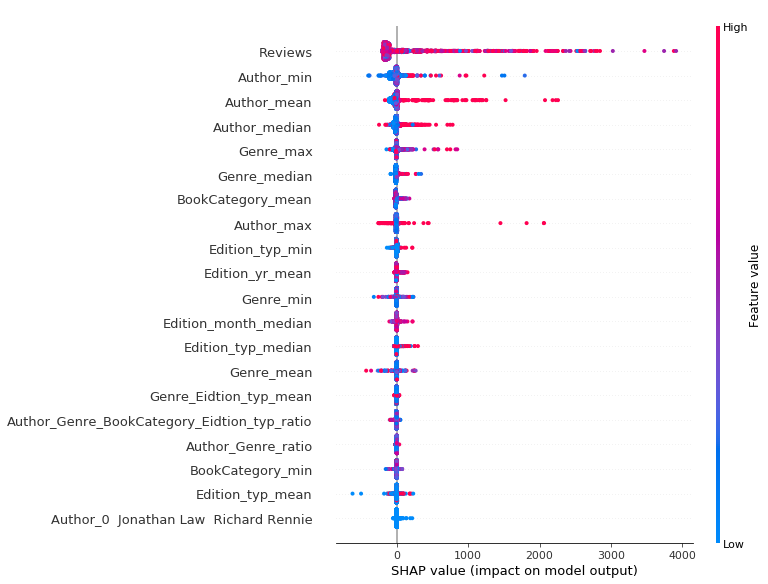

In [49]:
explainer = shap.TreeExplainer(cbc)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [50]:
cbc.get_feature_importance(prettified=True)

,Feature Index,Importances
0,Author_mean,33.900998
1,Author_median,18.017235
2,Author_max,10.266904
3,Genre_max,6.858992
4,Author_min,6.105960
5,Edition_yr_max,2.532429
6,Genre_BookCategory_Eidtion_typ_mean,2.253499
7,Reviews_max,2.251257
8,Edition_month_max,1.456206
9,Author_Genre_Eidtion_typ_ratio,1.166168


In [51]:
from sklearn.ensemble import RandomForestRegressor

In [52]:
rfr = RandomForestRegressor(n_estimators=300,
                            oob_score=True,
                            n_jobs=-1,
                            random_state=42,
                            max_features="auto",
                            min_samples_leaf=50
                           )

In [53]:
rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=50, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [54]:
y_pred_rfr=rfr.predict(X_test)
y_pred_rfr[y_pred_rfr<0] = 0
1-np.sqrt(mean_squared_log_error(y_pred_rfr,y_test))

0.6991769730239814

In [94]:
data_synp = pd.read_csv('D:\Hands on ML\Machine Hack Predict The Price of Books\synopsis.csv')

In [104]:
data_synp.head()
# data_synp.shape

,Unnamed: 0,Synopsis_feat,avg_price,flag
0,0,kuzneski set ten classic guided discovered raw...,220.00,train
1,1,innovative carefully style written aur rhythm ...,202.93,train
2,2,peace being text global contemporary competiti...,299.00,train
3,3,financial house fortescue sudden marple empire...,180.00,train
4,4,seven photojournalism photo spectrum one socie...,965.62,train


In [96]:
data_synp = data_synp.drop(data_synp.index[317])

In [103]:
data_synp.loc[data_synp['flag']=='train'].shape

(6122, 4)

In [66]:
data_synp['Synopsis_feat'] = data_synp['Synopsis']
data_synp['Synopsis_feat'] = data_synp['Synopsis_feat'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data_synp['Synopsis_feat'] = data_synp['Synopsis_feat'].replace('[^\w\s]','')
data_synp['Synopsis_feat'] = data_synp['Synopsis_feat'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data_synp['Synopsis_feat'] = data_synp['Synopsis_feat'].apply(lambda x: re.sub('[^a-zA-Z \n\.]', ' ', x))
data_synp['Synopsis_feat'] = data_synp['Synopsis_feat'].apply(lambda x: " ".join(x for x in x.split() if len(x) > 2))
data_synp['Synopsis_feat'] = data_synp['Synopsis_feat'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data_synp['Synopsis_feat'] = data_synp['Synopsis_feat'].apply(lambda x: " ".join(x for x in x.split() if len(x) > 2))
data_synp['Synopsis_feat'] = data_synp['Synopsis_feat'].apply(lambda x: " ".join(x for x in set(x.split())))

D:\ds\ds_venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\ds\ds_venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\ds\ds_venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

NameError: global name 'stop' is not defined

In [110]:
mapper = DataFrameMapper([
    ('Synopsis_feat',CountVectorizer(binary=True, ngram_range=(0,1),max_features=5000)),
    ('Synopsis_feat',TfidfVectorizer(smooth_idf=True,max_features=5000)) 
])

In [111]:
data_uniq_mapped = mapper.fit_transform(data_synp)

In [112]:
data_uniq_mapped.shape

(7671L, 10000L)

In [113]:
X=data_uniq_mapped[:6122,:]
y=data_synp[:6122]['avg_price']

In [114]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=42)

In [107]:
from catboost import Pool, CatBoostRegressor

In [108]:
cbc = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.03,
    random_strength=0.1,
    depth=6,
    eval_metric='MSLE',
    leaf_estimation_method='Gradient'
#     cat_features=['Author','Genre','BookCategory','Edition_yr','Edition_month','Edition_typ']
)

In [115]:
cbc.fit(X_train,y_train)

0:	learn: 10.4340867	total: 2.38s	remaining: 39m 42s
1:	learn: 6.7193777	total: 4.43s	remaining: 36m 50s
2:	learn: 4.9541503	total: 6.29s	remaining: 34m 50s
3:	learn: 3.9028775	total: 8.04s	remaining: 33m 23s
4:	learn: 3.1847894	total: 10s	remaining: 33m 11s
5:	learn: 2.6689640	total: 12s	remaining: 33m
6:	learn: 2.2781029	total: 13.7s	remaining: 32m 25s
7:	learn: 1.9804706	total: 15.4s	remaining: 31m 50s
8:	learn: 1.7423728	total: 17.2s	remaining: 31m 34s
9:	learn: 1.5514541	total: 18.8s	remaining: 31m 5s
10:	learn: 1.3937953	total: 20.7s	remaining: 31m 3s
11:	learn: 1.2632026	total: 22.9s	remaining: 31m 22s
12:	learn: 1.1512199	total: 25s	remaining: 31m 34s
13:	learn: 1.0591770	total: 26.8s	remaining: 31m 26s
14:	learn: 0.9782171	total: 28.8s	remaining: 31m 33s
15:	learn: 0.9105759	total: 30.8s	remaining: 31m 34s
16:	learn: 0.8520338	total: 32.7s	remaining: 31m 31s
17:	learn: 0.8024548	total: 34.4s	remaining: 31m 15s
18:	learn: 0.7589152	total: 36.1s	remaining: 31m 6s
19:	learn: 0.72

153:	learn: 0.5222427	total: 4m 29s	remaining: 24m 37s
154:	learn: 0.5222613	total: 4m 30s	remaining: 24m 37s
155:	learn: 0.5222309	total: 4m 33s	remaining: 24m 37s
156:	learn: 0.5222410	total: 4m 35s	remaining: 24m 36s
157:	learn: 0.5221726	total: 4m 37s	remaining: 24m 36s
158:	learn: 0.5220858	total: 4m 39s	remaining: 24m 36s
159:	learn: 0.5218234	total: 4m 40s	remaining: 24m 34s
160:	learn: 0.5214042	total: 4m 42s	remaining: 24m 33s
161:	learn: 0.5213418	total: 4m 44s	remaining: 24m 32s
162:	learn: 0.5211495	total: 4m 46s	remaining: 24m 31s
163:	learn: 0.5212353	total: 4m 48s	remaining: 24m 31s
164:	learn: 0.5211650	total: 4m 50s	remaining: 24m 30s
165:	learn: 0.5210625	total: 4m 52s	remaining: 24m 31s
166:	learn: 0.5207251	total: 4m 54s	remaining: 24m 31s
167:	learn: 0.5206248	total: 4m 56s	remaining: 24m 29s
168:	learn: 0.5205816	total: 4m 58s	remaining: 24m 28s
169:	learn: 0.5205313	total: 5m	remaining: 24m 27s
170:	learn: 0.5204405	total: 5m 2s	remaining: 24m 26s
171:	learn: 0.5

303:	learn: 0.5040439	total: 8m 45s	remaining: 20m 4s
304:	learn: 0.5039541	total: 8m 47s	remaining: 20m 1s
305:	learn: 0.5038568	total: 8m 48s	remaining: 19m 58s
306:	learn: 0.5037537	total: 8m 49s	remaining: 19m 56s
307:	learn: 0.5036723	total: 8m 51s	remaining: 19m 54s
308:	learn: 0.5033380	total: 8m 53s	remaining: 19m 52s
309:	learn: 0.5032755	total: 8m 54s	remaining: 19m 50s
310:	learn: 0.5030034	total: 8m 56s	remaining: 19m 47s
311:	learn: 0.5029699	total: 8m 57s	remaining: 19m 45s
312:	learn: 0.5029068	total: 8m 58s	remaining: 19m 42s
313:	learn: 0.5025668	total: 9m	remaining: 19m 40s
314:	learn: 0.5024371	total: 9m 1s	remaining: 19m 37s
315:	learn: 0.5023833	total: 9m 2s	remaining: 19m 35s
316:	learn: 0.5021497	total: 9m 4s	remaining: 19m 32s
317:	learn: 0.5020339	total: 9m 5s	remaining: 19m 30s
318:	learn: 0.5019026	total: 9m 7s	remaining: 19m 27s
319:	learn: 0.5016035	total: 9m 8s	remaining: 19m 25s
320:	learn: 0.5015233	total: 9m 9s	remaining: 19m 22s
321:	learn: 0.5014475	t

452:	learn: 0.4902638	total: 12m 17s	remaining: 14m 50s
453:	learn: 0.4901717	total: 12m 19s	remaining: 14m 48s
454:	learn: 0.4901409	total: 12m 20s	remaining: 14m 46s
455:	learn: 0.4901091	total: 12m 21s	remaining: 14m 44s
456:	learn: 0.4901097	total: 12m 23s	remaining: 14m 43s
457:	learn: 0.4901011	total: 12m 24s	remaining: 14m 40s
458:	learn: 0.4900057	total: 12m 25s	remaining: 14m 39s
459:	learn: 0.4898003	total: 12m 27s	remaining: 14m 37s
460:	learn: 0.4897094	total: 12m 28s	remaining: 14m 35s
461:	learn: 0.4896147	total: 12m 30s	remaining: 14m 33s
462:	learn: 0.4895958	total: 12m 31s	remaining: 14m 31s
463:	learn: 0.4895176	total: 12m 33s	remaining: 14m 30s
464:	learn: 0.4895064	total: 12m 34s	remaining: 14m 28s
465:	learn: 0.4894522	total: 12m 36s	remaining: 14m 26s
466:	learn: 0.4893851	total: 12m 37s	remaining: 14m 24s
467:	learn: 0.4893139	total: 12m 38s	remaining: 14m 22s
468:	learn: 0.4892548	total: 12m 40s	remaining: 14m 20s
469:	learn: 0.4892153	total: 12m 41s	remaining: 

600:	learn: 0.4773527	total: 16m 13s	remaining: 10m 46s
601:	learn: 0.4773221	total: 16m 14s	remaining: 10m 44s
602:	learn: 0.4773099	total: 16m 16s	remaining: 10m 42s
603:	learn: 0.4772910	total: 16m 17s	remaining: 10m 40s
604:	learn: 0.4772620	total: 16m 19s	remaining: 10m 39s
605:	learn: 0.4772239	total: 16m 20s	remaining: 10m 37s
606:	learn: 0.4771358	total: 16m 21s	remaining: 10m 35s
607:	learn: 0.4770614	total: 16m 23s	remaining: 10m 33s
608:	learn: 0.4769738	total: 16m 24s	remaining: 10m 32s
609:	learn: 0.4769505	total: 16m 25s	remaining: 10m 30s
610:	learn: 0.4769319	total: 16m 27s	remaining: 10m 28s
611:	learn: 0.4769015	total: 16m 28s	remaining: 10m 26s
612:	learn: 0.4768908	total: 16m 29s	remaining: 10m 24s
613:	learn: 0.4768866	total: 16m 31s	remaining: 10m 23s
614:	learn: 0.4768883	total: 16m 32s	remaining: 10m 21s
615:	learn: 0.4768821	total: 16m 34s	remaining: 10m 19s
616:	learn: 0.4768610	total: 16m 35s	remaining: 10m 17s
617:	learn: 0.4768165	total: 16m 36s	remaining: 

750:	learn: 0.4686224	total: 20m 4s	remaining: 6m 39s
751:	learn: 0.4683623	total: 20m 6s	remaining: 6m 37s
752:	learn: 0.4683421	total: 20m 7s	remaining: 6m 36s
753:	learn: 0.4683011	total: 20m 9s	remaining: 6m 34s
754:	learn: 0.4682893	total: 20m 10s	remaining: 6m 32s
755:	learn: 0.4682694	total: 20m 12s	remaining: 6m 31s
756:	learn: 0.4681840	total: 20m 14s	remaining: 6m 29s
757:	learn: 0.4681982	total: 20m 15s	remaining: 6m 28s
758:	learn: 0.4682068	total: 20m 17s	remaining: 6m 26s
759:	learn: 0.4681074	total: 20m 18s	remaining: 6m 24s
760:	learn: 0.4680478	total: 20m 20s	remaining: 6m 23s
761:	learn: 0.4679555	total: 20m 22s	remaining: 6m 21s
762:	learn: 0.4678980	total: 20m 23s	remaining: 6m 20s
763:	learn: 0.4678749	total: 20m 25s	remaining: 6m 18s
764:	learn: 0.4678666	total: 20m 26s	remaining: 6m 16s
765:	learn: 0.4678240	total: 20m 28s	remaining: 6m 15s
766:	learn: 0.4678315	total: 20m 30s	remaining: 6m 13s
767:	learn: 0.4677910	total: 20m 31s	remaining: 6m 12s
768:	learn: 0.

901:	learn: 0.4616548	total: 24m	remaining: 2m 36s
902:	learn: 0.4616402	total: 24m 1s	remaining: 2m 34s
903:	learn: 0.4616282	total: 24m 3s	remaining: 2m 33s
904:	learn: 0.4613042	total: 24m 5s	remaining: 2m 31s
905:	learn: 0.4612850	total: 24m 7s	remaining: 2m 30s
906:	learn: 0.4612733	total: 24m 9s	remaining: 2m 28s
907:	learn: 0.4612199	total: 24m 10s	remaining: 2m 26s
908:	learn: 0.4612171	total: 24m 12s	remaining: 2m 25s
909:	learn: 0.4612061	total: 24m 13s	remaining: 2m 23s
910:	learn: 0.4611774	total: 24m 15s	remaining: 2m 22s
911:	learn: 0.4611819	total: 24m 17s	remaining: 2m 20s
912:	learn: 0.4611497	total: 24m 18s	remaining: 2m 18s
913:	learn: 0.4611278	total: 24m 20s	remaining: 2m 17s
914:	learn: 0.4611030	total: 24m 21s	remaining: 2m 15s
915:	learn: 0.4609416	total: 24m 23s	remaining: 2m 14s
916:	learn: 0.4609317	total: 24m 25s	remaining: 2m 12s
917:	learn: 0.4609471	total: 24m 27s	remaining: 2m 11s
918:	learn: 0.4609076	total: 24m 28s	remaining: 2m 9s
919:	learn: 0.460896

In [116]:
y_pred_cbc=cbc.predict(X_test)
y_pred_cbc[y_pred_cbc<0] = 0
1-np.sqrt(mean_squared_log_error(y_pred_cbc,y_test))

0.2515274018373205

In [119]:
poly = PolynomialFeatures(degree=2)

In [130]:
X_poly = poly.fit_transform(X_train[list(feat_imp.loc[feat_imp['Importances']>0.1]['Feature Index'])])

In [131]:
cbc_poly.fit(X_poly,y_train)

0:	learn: 5.0962303	total: 6.08s	remaining: 1h 41m 17s
1:	learn: 2.6387186	total: 12s	remaining: 1h 39m 46s
2:	learn: 1.6387806	total: 17.9s	remaining: 1h 39m 12s
3:	learn: 1.1069044	total: 23.8s	remaining: 1h 38m 47s
4:	learn: 0.7856689	total: 30.1s	remaining: 1h 39m 42s
5:	learn: 0.5783319	total: 36.4s	remaining: 1h 40m 23s
6:	learn: 0.4365247	total: 42.6s	remaining: 1h 40m 46s
7:	learn: 0.3377963	total: 48.7s	remaining: 1h 40m 37s
8:	learn: 0.2696408	total: 54.8s	remaining: 1h 40m 38s
9:	learn: 0.2211645	total: 1m	remaining: 1h 40m 18s
10:	learn: 0.1822535	total: 1m 7s	remaining: 1h 40m 33s
11:	learn: 0.1561597	total: 1m 13s	remaining: 1h 41m 17s
12:	learn: 0.1366272	total: 1m 20s	remaining: 1h 42m 7s
13:	learn: 0.1228305	total: 1m 27s	remaining: 1h 42m 27s
14:	learn: 0.1108722	total: 1m 33s	remaining: 1h 42m 36s
15:	learn: 0.1029849	total: 1m 40s	remaining: 1h 42m 41s
16:	learn: 0.0972514	total: 1m 46s	remaining: 1h 42m 38s
17:	learn: 0.0928102	total: 1m 52s	remaining: 1h 42m 34s
1

144:	learn: 0.0818573	total: 15m 13s	remaining: 1h 29m 49s
145:	learn: 0.0818393	total: 15m 20s	remaining: 1h 29m 43s
146:	learn: 0.0818109	total: 15m 26s	remaining: 1h 29m 35s
147:	learn: 0.0817946	total: 15m 32s	remaining: 1h 29m 27s
148:	learn: 0.0817547	total: 15m 38s	remaining: 1h 29m 19s
149:	learn: 0.0817519	total: 15m 44s	remaining: 1h 29m 11s
150:	learn: 0.0817435	total: 15m 50s	remaining: 1h 29m 4s
151:	learn: 0.0816965	total: 15m 56s	remaining: 1h 28m 57s
152:	learn: 0.0817068	total: 16m 3s	remaining: 1h 28m 51s
153:	learn: 0.0816963	total: 16m 9s	remaining: 1h 28m 44s
154:	learn: 0.0816568	total: 16m 15s	remaining: 1h 28m 38s
155:	learn: 0.0816858	total: 16m 21s	remaining: 1h 28m 32s
156:	learn: 0.0816747	total: 16m 28s	remaining: 1h 28m 25s
157:	learn: 0.0816085	total: 16m 34s	remaining: 1h 28m 19s
158:	learn: 0.0816094	total: 16m 40s	remaining: 1h 28m 12s
159:	learn: 0.0815750	total: 16m 46s	remaining: 1h 28m 5s
160:	learn: 0.0815533	total: 16m 53s	remaining: 1h 27m 59s
1

284:	learn: 0.0803079	total: 29m 51s	remaining: 1h 14m 54s
285:	learn: 0.0803177	total: 29m 57s	remaining: 1h 14m 47s
286:	learn: 0.0803219	total: 30m 3s	remaining: 1h 14m 41s
287:	learn: 0.0803262	total: 30m 10s	remaining: 1h 14m 35s
288:	learn: 0.0803172	total: 30m 16s	remaining: 1h 14m 29s
289:	learn: 0.0803184	total: 30m 22s	remaining: 1h 14m 23s
290:	learn: 0.0803262	total: 30m 29s	remaining: 1h 14m 17s
291:	learn: 0.0803388	total: 30m 35s	remaining: 1h 14m 10s
292:	learn: 0.0803360	total: 30m 41s	remaining: 1h 14m 4s
293:	learn: 0.0803323	total: 30m 48s	remaining: 1h 13m 59s
294:	learn: 0.0802917	total: 30m 55s	remaining: 1h 13m 53s
295:	learn: 0.0802868	total: 31m 1s	remaining: 1h 13m 47s
296:	learn: 0.0802512	total: 31m 7s	remaining: 1h 13m 40s
297:	learn: 0.0802502	total: 31m 14s	remaining: 1h 13m 36s
298:	learn: 0.0802114	total: 31m 21s	remaining: 1h 13m 30s
299:	learn: 0.0801875	total: 31m 27s	remaining: 1h 13m 24s
300:	learn: 0.0801728	total: 31m 33s	remaining: 1h 13m 17s
3

426:	learn: 0.0783338	total: 45m 23s	remaining: 1h 55s
427:	learn: 0.0783339	total: 45m 29s	remaining: 1h 48s
428:	learn: 0.0783301	total: 45m 35s	remaining: 1h 41s
429:	learn: 0.0783383	total: 45m 41s	remaining: 1h 34s
430:	learn: 0.0782715	total: 45m 47s	remaining: 1h 27s
431:	learn: 0.0782735	total: 45m 53s	remaining: 1h 20s
432:	learn: 0.0782755	total: 45m 59s	remaining: 1h 13s
433:	learn: 0.0782780	total: 46m 5s	remaining: 1h 6s
434:	learn: 0.0782481	total: 46m 11s	remaining: 59m 59s
435:	learn: 0.0782552	total: 46m 17s	remaining: 59m 52s
436:	learn: 0.0782443	total: 46m 23s	remaining: 59m 45s
437:	learn: 0.0782446	total: 46m 29s	remaining: 59m 38s
438:	learn: 0.0782522	total: 46m 35s	remaining: 59m 31s
439:	learn: 0.0782468	total: 46m 40s	remaining: 59m 24s
440:	learn: 0.0782013	total: 46m 46s	remaining: 59m 17s
441:	learn: 0.0782057	total: 46m 52s	remaining: 59m 11s
442:	learn: 0.0781970	total: 46m 58s	remaining: 59m 4s
443:	learn: 0.0781991	total: 47m 4s	remaining: 58m 57s
444:

574:	learn: 0.0769983	total: 1h 41s	remaining: 44m 51s
575:	learn: 0.0769952	total: 1h 47s	remaining: 44m 45s
576:	learn: 0.0769766	total: 1h 54s	remaining: 44m 38s
577:	learn: 0.0769744	total: 1h 1m	remaining: 44m 32s
578:	learn: 0.0769739	total: 1h 1m 7s	remaining: 44m 26s
579:	learn: 0.0769712	total: 1h 1m 14s	remaining: 44m 20s
580:	learn: 0.0769450	total: 1h 1m 20s	remaining: 44m 14s
581:	learn: 0.0769438	total: 1h 1m 27s	remaining: 44m 8s
582:	learn: 0.0769445	total: 1h 1m 34s	remaining: 44m 2s
583:	learn: 0.0769468	total: 1h 1m 41s	remaining: 43m 56s
584:	learn: 0.0769415	total: 1h 1m 48s	remaining: 43m 50s
585:	learn: 0.0769438	total: 1h 1m 55s	remaining: 43m 44s
586:	learn: 0.0769209	total: 1h 2m 2s	remaining: 43m 38s
587:	learn: 0.0769165	total: 1h 2m 8s	remaining: 43m 32s
588:	learn: 0.0768738	total: 1h 2m 14s	remaining: 43m 25s
589:	learn: 0.0768298	total: 1h 2m 20s	remaining: 43m 19s
590:	learn: 0.0768311	total: 1h 2m 26s	remaining: 43m 12s
591:	learn: 0.0768322	total: 1h 

716:	learn: 0.0762366	total: 1h 15m 24s	remaining: 29m 45s
717:	learn: 0.0762356	total: 1h 15m 30s	remaining: 29m 39s
718:	learn: 0.0762343	total: 1h 15m 35s	remaining: 29m 32s
719:	learn: 0.0762352	total: 1h 15m 41s	remaining: 29m 26s
720:	learn: 0.0762163	total: 1h 15m 48s	remaining: 29m 20s
721:	learn: 0.0762204	total: 1h 15m 54s	remaining: 29m 13s
722:	learn: 0.0762177	total: 1h 16m	remaining: 29m 7s
723:	learn: 0.0762174	total: 1h 16m 6s	remaining: 29m
724:	learn: 0.0762162	total: 1h 16m 12s	remaining: 28m 54s
725:	learn: 0.0762169	total: 1h 16m 18s	remaining: 28m 47s
726:	learn: 0.0761730	total: 1h 16m 23s	remaining: 28m 41s
727:	learn: 0.0761348	total: 1h 16m 29s	remaining: 28m 34s
728:	learn: 0.0761364	total: 1h 16m 35s	remaining: 28m 28s
729:	learn: 0.0760531	total: 1h 16m 41s	remaining: 28m 21s
730:	learn: 0.0760587	total: 1h 16m 47s	remaining: 28m 15s
731:	learn: 0.0760590	total: 1h 16m 52s	remaining: 28m 8s
732:	learn: 0.0760575	total: 1h 16m 58s	remaining: 28m 2s
733:	lear

856:	learn: 0.0749167	total: 1h 30m 4s	remaining: 15m 1s
857:	learn: 0.0749165	total: 1h 30m 12s	remaining: 14m 55s
858:	learn: 0.0749212	total: 1h 30m 20s	remaining: 14m 49s
859:	learn: 0.0749180	total: 1h 30m 29s	remaining: 14m 43s
860:	learn: 0.0749196	total: 1h 30m 36s	remaining: 14m 37s
861:	learn: 0.0748596	total: 1h 30m 44s	remaining: 14m 31s
862:	learn: 0.0748617	total: 1h 30m 52s	remaining: 14m 25s
863:	learn: 0.0748463	total: 1h 30m 59s	remaining: 14m 19s
864:	learn: 0.0748465	total: 1h 31m 6s	remaining: 14m 13s
865:	learn: 0.0748426	total: 1h 31m 13s	remaining: 14m 7s
866:	learn: 0.0748439	total: 1h 31m 21s	remaining: 14m
867:	learn: 0.0748485	total: 1h 31m 28s	remaining: 13m 54s
868:	learn: 0.0748545	total: 1h 31m 36s	remaining: 13m 48s
869:	learn: 0.0748506	total: 1h 31m 44s	remaining: 13m 42s
870:	learn: 0.0748518	total: 1h 31m 52s	remaining: 13m 36s
871:	learn: 0.0748552	total: 1h 31m 59s	remaining: 13m 30s
872:	learn: 0.0748584	total: 1h 32m 7s	remaining: 13m 24s
873:	l

998:	learn: 0.0741894	total: 1h 48m 12s	remaining: 6.5s
999:	learn: 0.0741889	total: 1h 48m 18s	remaining: 0us


In [133]:
y_pred_cbc=cbc_poly.predict(X_test)
y_pred_cbc[y_pred_cbc<0] = 0
np.sqrt(mean_squared_log_error(y_pred_cbc,y_test))

1.8260094323453908